Run this code in order: the different sections are labeled

In [2]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 4.4 MB/s eta 0:00:00


# Initial Fixed Route experiments

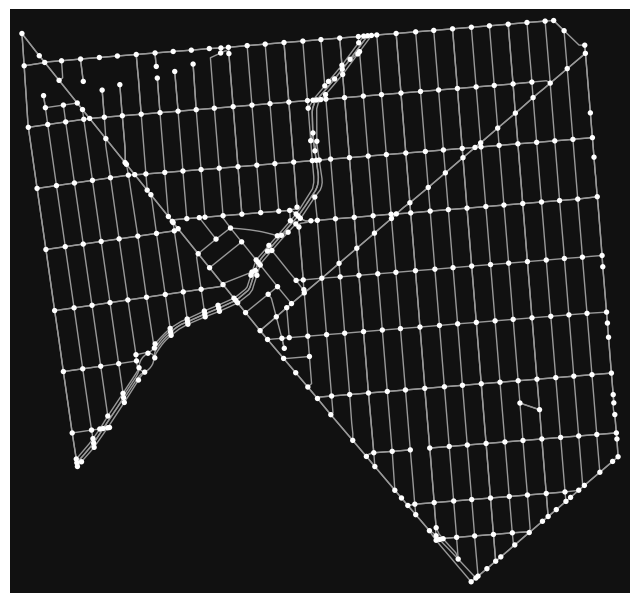

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [59]:
# Creation of Network
import osmnx as ox
import geopandas as gpd

# use geojson file to filter OSM network to just Flatlands
gdf = gpd.read_file("map.geojson")
polygon = gdf.geometry.values[0]
G = ox.graph_from_polygon(polygon, network_type='drive')

ox.plot_graph(G)

In [34]:
ox.save_graphml(G, filepath='flatlands.graphml')

In [45]:
# find subway node ID
subway_lat, subway_lon = 40.63283, -73.9476

subway_node = ox.nearest_nodes(G, X=subway_lon, Y=subway_lat)
print(subway_node)

9258552694


In [46]:
# create N synthetic demand nodes
import random
import networkx as nx

demand_nodes = random.sample(list(G.nodes), 300)

In [47]:
# use KMeans to cluster demand nodes to determine stop locations
from sklearn.cluster import KMeans
import numpy as np

X = np.array([[G.nodes[n]['x'], G.nodes[n]['y']] for n in demand_nodes])

k = 12
kmeans = KMeans(n_clusters=k).fit(X)

stop_coords = kmeans.cluster_centers_

In [48]:
stop_nodes = [ox.nearest_nodes(G, pt[0], pt[1]) for pt in stop_coords]

In [49]:
subway_node = 9258552694

# add subway node
if subway_node not in stop_nodes:
    stop_nodes.append(subway_node)

In [50]:
import networkx as nx
import itertools

# convert graph to undirected - assumption
G_undirected = G.to_undirected()

stop_graph = nx.Graph()

for u, v in itertools.combinations(stop_nodes, 2):
    try:
        length = nx.shortest_path_length(G_undirected, u, v, weight='length')
        stop_graph.add_edge(u, v, weight=length)
    except nx.NetworkXNoPath:
        continue

tsp_route = nx.approximation.traveling_salesman_problem(stop_graph, weight='weight', cycle=True)

In [51]:
# expands TSP route to a route that traverses the flatlands street network
full_route = []
for i in range(len(tsp_route)):
    u = tsp_route[i]
    v = tsp_route[(i + 1) % len(tsp_route)]
    path = nx.shortest_path(G_undirected, u, v, weight='length')
    full_route += path[:-1]
full_route.append(tsp_route[0])

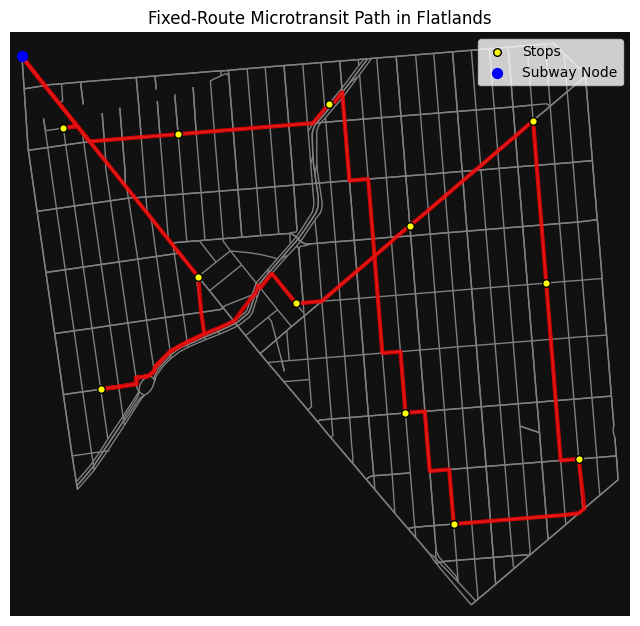

In [52]:
# plots route on Flatlands network graph
import matplotlib.pyplot as plt
import osmnx as ox

fig, ax = ox.plot_graph(G, node_size=0, edge_color='gray', show=False, close=False)

x = [G.nodes[n]['x'] for n in full_route]
y = [G.nodes[n]['y'] for n in full_route]

ax.plot(x, y, color='red', linewidth=3, alpha=0.8, zorder=2)

stop_x = [G.nodes[n]['x'] for n in stop_nodes]
stop_y = [G.nodes[n]['y'] for n in stop_nodes]
ax.scatter(stop_x, stop_y, c='yellow', s=30, edgecolors='black', zorder=3, label='Stops')

ax.scatter([G.nodes[subway_node]['x']], [G.nodes[subway_node]['y']], c='blue', s=50, label='Subway Node', zorder=4)

plt.legend()
plt.title("Fixed-Route Microtransit Path in Flatlands")
plt.show()

# Stop coverage map

In [53]:
radius = 600
min_dist_between_stops = 600
G_undirected = G.to_undirected()

coverage = {}
for node in G_undirected.nodes:
    reachable = nx.single_source_dijkstra_path_length(G_undirected, node, cutoff=radius, weight='length')
    coverage[node] = set(reachable.keys())

edges = ox.graph_to_gdfs(G_undirected, nodes=False)

major_highways = ['primary', 'secondary', 'tertiary', 'trunk']
major_edges = edges[edges['highway'].apply(lambda hw: any(h in hw if isinstance(hw, list) else [hw] for h in major_highways))]


major_nodes = set(major_edges.index.get_level_values('u')) | set(major_edges.index.get_level_values('v'))

all_nodes = set(G_undirected.nodes)

uncovered = all_nodes.copy()
available = set(G_undirected.nodes)
stops = [9258552694]

while uncovered and available:
    if not available:
        print("Warning: No available nodes left to cover the remaining nodes.")
        break

    best_node = max(
        available,
        key=lambda n: len(coverage.get(n, set()) & uncovered)
    )

    stops.append(best_node)
    uncovered -= coverage.get(best_node, set())

    if best_node in G_undirected:
        too_close = nx.single_source_dijkstra_path_length(G_undirected, best_node, cutoff=min_dist_between_stops, weight='length')
        available -= set(too_close.keys())
    else:
        print(f"Warning: Selected best_node {best_node} not found in G_undirected.")
        available.discard(best_node)

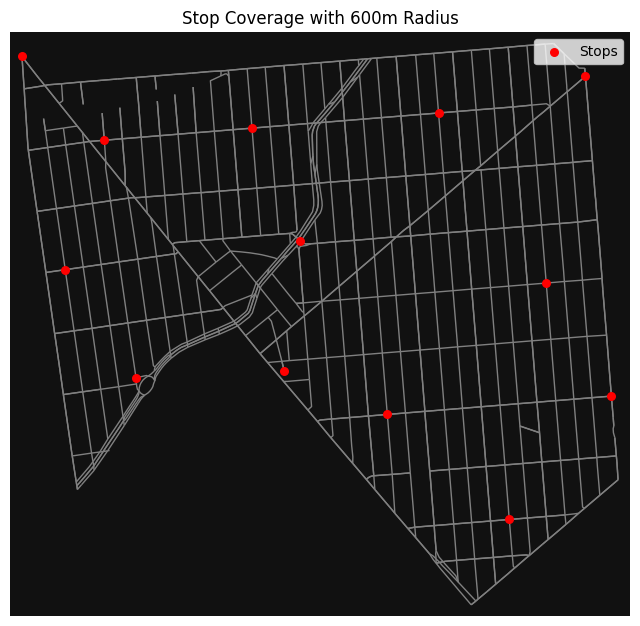

In [54]:
import matplotlib.pyplot as plt
fig, ax = ox.plot_graph(G, node_size=0, edge_color='gray', show=False, close=False)

stop_x = [G.nodes[n]['x'] for n in stops]
stop_y = [G.nodes[n]['y'] for n in stops]
ax.scatter(stop_x, stop_y, c='red', s=30, label='Stops', zorder=3)

plt.title("Stop Coverage with 600m Radius")
plt.legend()
plt.show()

# Testing Automatically Created Stops with Arterial Filtering

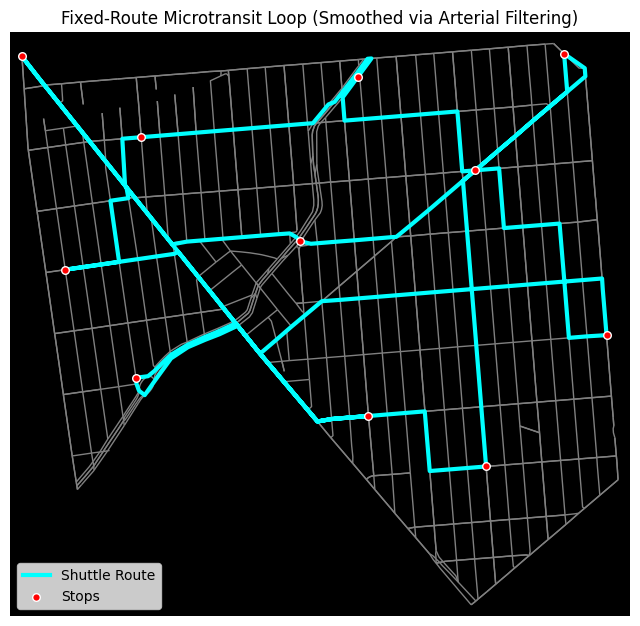

In [55]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from networkx.algorithms.shortest_paths.dense import floyd_warshall

G_undirected = G.to_undirected()

edges = ox.graph_to_gdfs(G_undirected, nodes=False)

major_highways = ['primary', 'secondary', 'tertiary', 'trunk']
major_edges = edges[edges['highway'].apply(lambda hw: any(h in hw if isinstance(hw, list) else [hw] for h in major_highways))]

major_nodes = set([u for u, v, k in major_edges.index] + [v for u, v, k in major_edges.index])

radius = 750
coverage = {}
for node in major_nodes:
    reachable = nx.single_source_dijkstra_path_length(G_undirected, node, cutoff=radius, weight='length')
    coverage[node] = set(reachable.keys())

all_nodes = set(G_undirected.nodes)
uncovered = all_nodes.copy()
available = major_nodes.copy()
stops = [9258552694]
min_spacing = 750

while uncovered and available:
    best_node = max(available, key=lambda n: len(coverage[n] & uncovered))
    stops.append(best_node)
    uncovered -= coverage[best_node]

    too_close = nx.single_source_dijkstra_path_length(G_undirected, best_node, cutoff=min_spacing, weight='length')
    available -= set(too_close.keys())
stop_subgraph = G_undirected.subgraph(stops).copy()
distance_matrix = floyd_warshall(stop_subgraph, weight='length')

tsp_graph = nx.Graph()
for u in stops:
    for v in stops:
        if u != v:
            tsp_graph.add_edge(u, v, weight=distance_matrix[u][v])

tsp_order = nx.approximation.traveling_salesman_problem(tsp_graph, cycle=True)

full_route = []
for i in range(len(tsp_order)):
    u = tsp_order[i]
    v = tsp_order[(i + 1) % len(tsp_order)]
    path = nx.shortest_path(G_undirected, u, v, weight='length')
    full_route.extend(path[:-1])
full_route.append(tsp_order[0])

fig, ax = ox.plot_graph(G, node_size=0, edge_color='gray', show=False, close=False, bgcolor='black')
x = [G.nodes[n]['x'] for n in full_route]
y = [G.nodes[n]['y'] for n in full_route]
ax.plot(x, y, color='cyan', linewidth=3, zorder=2, label='Shuttle Route')

stop_x = [G.nodes[n]['x'] for n in stops]
stop_y = [G.nodes[n]['y'] for n in stops]
ax.scatter(stop_x, stop_y, c='red', s=30, edgecolors='white', label='Stops', zorder=3)

plt.title("Fixed-Route Microtransit Loop (Smoothed via Arterial Filtering)")
plt.legend()
plt.show()

# Manually determined stops

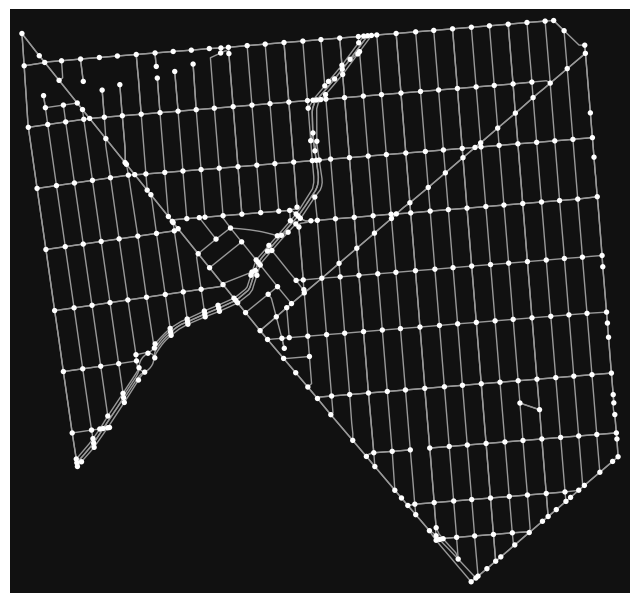

In [20]:
import osmnx as ox
import geopandas as gpd

gdf = gpd.read_file("map.geojson")

polygon = gdf.geometry.values[0]
G = ox.graph_from_polygon(polygon, network_type='drive')

ox.plot_graph(G)

ox.save_graphml(G, filepath='flatlands.graphml')

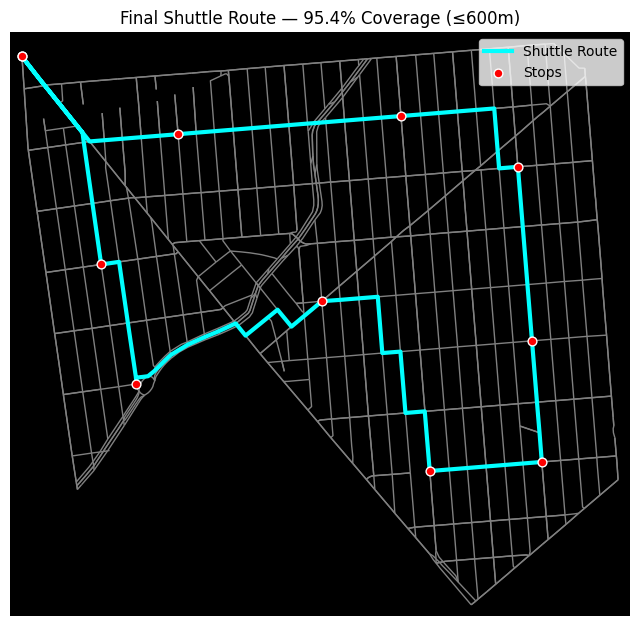

In [57]:
# PLOT MANUALLY DETERMINED STOPS
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

G = ox.load_graphml('flatlands.graphml')
G_undirected = G.to_undirected()

stop_coords = [
    (40.632784485467454,-73.94754503089007),  # Nostrand & Flatbush
    (40.62981145644909,-73.93960787941558),  # E 38th & Ave I
    (40.63051135001162,-73.92817570656266),  # Utica & Ave I
    (40.62854185381581,-73.92206598434407),  # E 56th & Ave J
    (40.6217183874659,-73.92132184069959),  # E 56th & Ave J
    (40.61695600800491,-73.92087468083865), # E 56th & Ave O
    (40.616624254162424,-73.92661209584033),  # Utica & Ave O
    (40.62331534931831,-73.93216887938968), # E 45th & Ave L
    (40.62003466520495,-73.94183041516024),  # E 34th & Ave M
    (40.624740007938314,-73.94355542954037),   # New York Ave & Ave K
    (40.632784485467454,-73.94754503089007) # Nostrand & Flatbush (loop end)
]

stop_nodes = [ox.nearest_nodes(G_undirected, lon, lat) for lat, lon in stop_coords]

full_route = []
for i in range(len(stop_nodes) - 1):
    u, v = stop_nodes[i], stop_nodes[i + 1]
    path = nx.shortest_path(G_undirected, u, v, weight='length')
    full_route.extend(path[:-1])
full_route.append(stop_nodes[-1])

radius = 600
covered_nodes = set()
for stop in stop_nodes:
    reachable = nx.single_source_dijkstra_path_length(G_undirected, stop, cutoff=radius, weight='length')
    covered_nodes.update(reachable.keys())
coverage_fraction = len(covered_nodes) / len(G_undirected.nodes)

fig, ax = ox.plot_graph(G, node_size=0, edge_color='gray', show=False, close=False, bgcolor='black')
x = [G.nodes[n]['x'] for n in full_route]
y = [G.nodes[n]['y'] for n in full_route]
ax.plot(x, y, color='cyan', linewidth=3, zorder=2, label='Shuttle Route')

stop_x = [G.nodes[n]['x'] for n in stop_nodes]
stop_y = [G.nodes[n]['y'] for n in stop_nodes]
ax.scatter(stop_x, stop_y, c='red', s=40, edgecolors='white', label='Stops', zorder=3)

plt.title(f"Final Shuttle Route — {coverage_fraction:.1%} Coverage (≤600m)")
plt.legend()
plt.show()

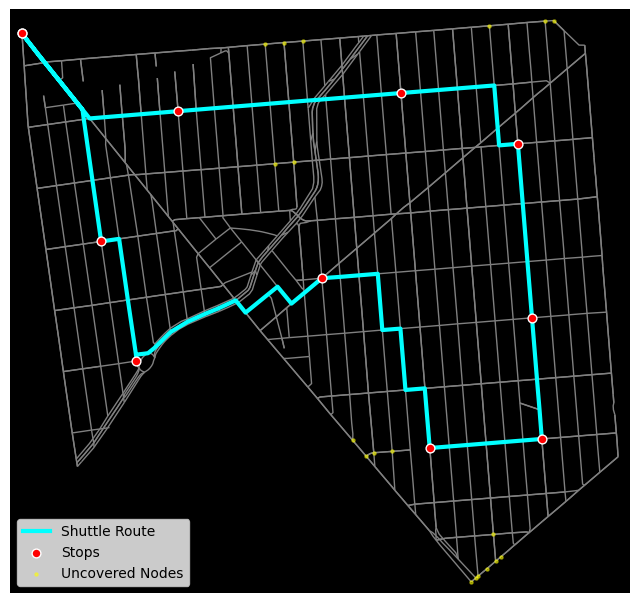

Number of total nodes: 415
Number of covered nodes: 396
Number of uncovered nodes: 19
Coverage fraction: 95.4%


In [58]:
# PLOT UNCOVERED AREAS

all_nodes = set(G_undirected.nodes)
uncovered_nodes = all_nodes - covered_nodes

uncovered_x = [G.nodes[n]['x'] for n in uncovered_nodes]
uncovered_y = [G.nodes[n]['y'] for n in uncovered_nodes]

fig, ax = ox.plot_graph(G, node_size=0, edge_color='gray', show=False, close=False, bgcolor='black')

x = [G.nodes[n]['x'] for n in full_route]
y = [G.nodes[n]['y'] for n in full_route]
ax.plot(x, y, color='cyan', linewidth=3, zorder=2, label='Shuttle Route')

stop_x = [G.nodes[n]['x'] for n in stop_nodes]
stop_y = [G.nodes[n]['y'] for n in stop_nodes]
ax.scatter(stop_x, stop_y, c='red', s=40, edgecolors='white', label='Stops', zorder=3)

ax.scatter(uncovered_x, uncovered_y, c='yellow', s=5, alpha=0.5, label='Uncovered Nodes', zorder=1)

plt.legend()
plt.show()

print(f"Number of total nodes: {len(all_nodes)}")
print(f"Number of covered nodes: {len(covered_nodes)}")
print(f"Number of uncovered nodes: {len(uncovered_nodes)}")
print(f"Coverage fraction: {coverage_fraction:.1%}")


In [6]:
# TOTAL ROUTE LENGTH & ESTIMATED TIME BASED ON NYC AVERAGE BUS SPEEDS

total_route_length = 0
for i in range(len(full_route) - 1):
  u = full_route[i]
  v = full_route[i+1]
  try:
    edge_data = G_undirected.get_edge_data(u, v)
    if edge_data:
      total_route_length += edge_data[0]['length']
  except KeyError:
    print(f"Warning: Could not find edge data for path segment {u} -> {v}")
    pass


print(f"Total route length: {total_route_length:.2f} meters")

average_speed_mps = 4

estimated_travel_time_sec = total_route_length / average_speed_mps

estimated_travel_time_min = estimated_travel_time_sec / 60

print(f"Total estimated route time (assuming {average_speed_mps:.2f} m/s): {estimated_travel_time_min:.2f} minutes")

Total route length: 8209.69 meters
Total estimated route time (assuming 4.00 m/s): 34.21 minutes


In [7]:
# ONE DIRECTIONAL SHUTTLE TRAVEL TIMES FROM EACH STOP TO DEST

cumulative_distance = {}
current_distance = 0
cumulative_distance[full_route[0]] = 0

for i in range(len(full_route) - 1):
  u = full_route[i]
  v = full_route[i+1]
  try:
    edge_data = G_undirected.get_edge_data(u, v)
    if edge_data:
      segment_length = edge_data[0]['length']
      current_distance += segment_length
      cumulative_distance[v] = current_distance
  except KeyError:
    print(f"Warning: Could not find edge data for path segment {u} -> {v}")
    pass

final_destination_node = full_route[-1]
total_route_distance = cumulative_distance[final_destination_node]

print("\nEstimated travel time from each stop to the final stop:")

for stop_node in stop_nodes:
    try:
        stop_index_in_route = full_route.index(stop_node)
        distance_to_stop = cumulative_distance[stop_node]

        distance_remaining = total_route_distance - distance_to_stop

        time_remaining_sec = distance_remaining / average_speed_mps
        time_remaining_min = time_remaining_sec / 60

        print(f"  Stop {stop_node} to final destination: {time_remaining_min:.2f} minutes ({distance_remaining:.2f} meters remaining)")

    except ValueError:
        print(f"Warning: Stop node {stop_node} was not found in the calculated full_route.")
    except KeyError:
        print(f"Error: Cumulative distance not found for stop node {stop_node}.")


Estimated travel time from each stop to the final stop:
  Stop 9258552694 to final destination: 0.00 minutes (0.00 meters remaining)
  Stop 42513959 to final destination: 30.63 minutes (7350.86 meters remaining)
  Stop 42521011 to final destination: 26.57 minutes (6377.79 meters remaining)
  Stop 42467756 to final destination: 23.45 minutes (5627.01 meters remaining)
  Stop 42467760 to final destination: 20.28 minutes (4867.28 meters remaining)
  Stop 42467766 to final destination: 18.08 minutes (4338.44 meters remaining)
  Stop 42521033 to final destination: 16.04 minutes (3849.02 meters remaining)
  Stop 42484539 to final destination: 11.11 minutes (2667.50 meters remaining)
  Stop 2317462527 to final destination: 6.74 minutes (1618.19 meters remaining)
  Stop 42496623 to final destination: 4.18 minutes (1002.88 meters remaining)
  Stop 9258552694 to final destination: 0.00 minutes (0.00 meters remaining)


In [8]:
# BIDIRECTIONAL SHUTTLE TRAVEL TIMES FROM EACH STOP TO DEST

last_stop_node = stop_nodes[-1]

print("\nEstimated travel time from each stop to the last stop:")

for i, start_stop_node in enumerate(stop_nodes):
  if i == len(stop_nodes) - 1:
    travel_time_min = 0
  else:
    try:
      shortest_path_length = nx.shortest_path_length(G_undirected, start_stop_node, last_stop_node, weight='length')

      travel_time_sec = shortest_path_length / average_speed_mps
      travel_time_min = travel_time_sec / 60
    except nx.NetworkXNoPath:
      travel_time_min = float('inf')

  print(f"Stop {i+1} (Node {start_stop_node}) to Last Stop (Node {last_stop_node}): {travel_time_min:.2f} minutes")


Estimated travel time from each stop to the last stop:
Stop 1 (Node 9258552694) to Last Stop (Node 9258552694): 0.00 minutes
Stop 2 (Node 42513959) to Last Stop (Node 9258552694): 3.58 minutes
Stop 3 (Node 42521011) to Last Stop (Node 9258552694): 7.63 minutes
Stop 4 (Node 42467756) to Last Stop (Node 9258552694): 10.25 minutes
Stop 5 (Node 42467760) to Last Stop (Node 9258552694): 11.93 minutes
Stop 6 (Node 42467766) to Last Stop (Node 9258552694): 13.49 minutes
Stop 7 (Node 42521033) to Last Stop (Node 9258552694): 11.56 minutes
Stop 8 (Node 42484539) to Last Stop (Node 9258552694): 7.93 minutes
Stop 9 (Node 2317462527) to Last Stop (Node 9258552694): 6.51 minutes
Stop 10 (Node 42496623) to Last Stop (Node 9258552694): 4.18 minutes
Stop 11 (Node 9258552694) to Last Stop (Node 9258552694): 0.00 minutes


In [60]:
one_loop_time_min = estimated_travel_time_min

print(f"\nEstimated time for one full loop: {one_loop_time_min:.2f} minutes")

num_stops = len(stop_nodes) - 1

print(f"Number of stops (excluding cycle end): {num_stops}")


cycle_time_min = one_loop_time_min

print(f"\nEstimated Cycle Time: {cycle_time_min:.2f} minutes")
print(f"Estimated Maximum Wait Time (Worst Case): {cycle_time_min:.2f} minutes")
print(f"Estimated Average Wait Time (Assuming Random Arrival): {cycle_time_min / 2:.2f} minutes")


Estimated time for one full loop: 34.21 minutes
Number of stops (excluding cycle end): 10

Estimated Cycle Time: 34.21 minutes
Estimated Maximum Wait Time (Worst Case): 34.21 minutes
Estimated Average Wait Time (Assuming Random Arrival): 17.10 minutes


# Mobility on Demand

In [29]:
import random
import networkx as nx

def generate_requests(graph, num_requests, fixed_destination_node):
    """
    Generates a list of random travel requests with a fixed destination node.

    Args:
        graph: The networkx graph of the road network.
        num_requests: The number of requests to generate.
        fixed_destination_node: The node ID that all requests should have as their destination.

    Returns:
        A list of travel requests.
    """
    all_nodes = list(graph.nodes())
    requests = []
    destination = fixed_destination_node

    if destination not in all_nodes:
        print(f"Error: Fixed destination node {destination} not found in the graph.")
        return []

    for i in range(num_requests):
        origin = random.choice(all_nodes)
        while origin == destination:
            origin = random.choice(all_nodes)

        requests.append({'id': i, 'origin': origin, 'destination': destination, 'arrival_time': i}) # Simple sequential time
    return requests

num_requests = 10
subway_node_id = 9258552694
travel_requests = generate_requests(G_undirected, num_requests, subway_node_id)

if travel_requests:
    print(travel_requests[:5])

[{'id': 0, 'origin': 2317435537, 'destination': 9258552694, 'arrival_time': 0}, {'id': 1, 'origin': 42487303, 'destination': 9258552694, 'arrival_time': 1}, {'id': 2, 'origin': 2063064664, 'destination': 9258552694, 'arrival_time': 2}, {'id': 3, 'origin': 42532778, 'destination': 9258552694, 'arrival_time': 3}, {'id': 4, 'origin': 42491804, 'destination': 9258552694, 'arrival_time': 4}]


In [30]:
def generate_vehicles(graph, num_vehicles, initial_locations):
    """Generates a list of vehicles with initial status."""
    vehicles = []
    for i in range(num_vehicles):
        if initial_locations and initial_locations[i % len(initial_locations)] in graph.nodes():
             current_location = initial_locations[i % len(initial_locations)]
        else:
             current_location = random.choice(list(graph.nodes()))

        vehicles.append({'id': i, 'current_location': current_location, 'capacity': 10, 'passengers': []})
    return vehicles

num_vehicles = 3
initial_vehicle_locations = stop_nodes[:-1] # Exclude the last duplicate stop
vehicles = generate_vehicles(G_undirected, num_vehicles, initial_vehicle_locations)
print(vehicles)

[{'id': 0, 'current_location': 9258552694, 'capacity': 10, 'passengers': []}, {'id': 1, 'current_location': 42513959, 'capacity': 10, 'passengers': []}, {'id': 2, 'current_location': 42521011, 'capacity': 10, 'passengers': []}]


In [27]:
import itertools
import networkx as nx

def generate_multi_request_trips(graph, requests, vehicles, max_detour_ratio=1.2):
    """
    Generates a list of potential trips, including combinations of requests
    up to the maximum vehicle capacity, respecting detour constraints.

    Args:
        graph: The networkx graph of the road network.
        requests: List of travel requests.
        vehicles: List of vehicle statuses (needed for capacity).
        max_detour_ratio: Maximum allowed ratio of shared trip length to individual trip length.

    Returns:
        A list of potential trips.
    """
    potential_trips = []
    max_capacity = max(v['capacity'] for v in vehicles) if vehicles else 1

    for k in range(1, max_capacity + 1):
        for request_combination in itertools.combinations(requests, k):
            request_ids = [req['id'] for req in request_combination]
            origins = [req['origin'] for req in request_combination]
            destinations = [req['destination'] for req in request_combination]
            try:
                total_individual_length = sum(nx.shortest_path_length(graph, req['origin'], req['destination'], weight='length')
                                              for req in request_combination)

                if len(origins) > 0:
                    route_nodes = []
                    route_nodes.extend(origins)
                    route_nodes.extend(destinations)
                    shared_length = 0
                    for i in range(len(route_nodes) - 1):
                        try:
                             shared_length += nx.shortest_path_length(graph, route_nodes[i], route_nodes[i+1], weight='length')
                        except nx.NetworkXNoPath:
                             shared_length = float('inf')
                             break

                    if shared_length != float('inf') and shared_length <= total_individual_length * max_detour_ratio:
                         potential_trips.append({'type': 'shared', 'requests': request_ids, 'cost': shared_length})

            except nx.NetworkXNoPath:
                 pass

    individual_requests_ids = set(req['id'] for req in requests)
    shared_requests_ids = set(req_id for trip in potential_trips if trip['type'] == 'shared' for req_id in trip['requests'])
    individual_only_requests = [req for req in requests if req['id'] not in shared_requests_ids]

    for req in individual_only_requests:
         try:
             length = nx.shortest_path_length(graph, req['origin'], req['destination'], weight='length')
             potential_trips.append({'type': 'individual', 'requests': [req['id']], 'cost': length})
         except nx.NetworkXNoPath:
             print(f"Warning: No path for individual trip for request {req['id']}")


    return potential_trips

potential_trips_multi = generate_multi_request_trips(G_undirected, travel_requests, vehicles)
print(f"\nGenerated {len(potential_trips_multi)} potential trips (including multi-request).")


Generated 1013 potential trips (including multi-request).


In [28]:
!pip install pulp
from pulp import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 60.7 MB/s eta 0:00:00


In [63]:
def solve_assignment_problem(requests, vehicles, potential_trips, penalty_unassigned=3000):
     """
     Solves the assignment problem to match vehicles to trips.

     Args:
         requests: List of travel requests.
         vehicles: List of vehicle statuses.
         potential_trips: List of potential trips (individual and shared).
         penalty_unassigned: Cost penalty for each unassigned request.

     Returns:
         A dictionary representing the assignment of vehicles to trips.
     """
     prob = LpProblem("Vehicle_Trip_Assignment", LpMinimize)

     x = LpVariable.dicts("assign", [(v['id'], t_idx) for v in vehicles for t_idx in range(len(potential_trips))], 0, 1, LpBinary)

     y = LpVariable.dicts("unassigned", [req['id'] for req in requests], 0, 1, LpBinary)

     prob += lpSum([potential_trips[t_idx]['cost'] * x[(v['id'], t_idx)] for v in vehicles for t_idx in range(len(potential_trips))]) + \
             lpSum([penalty_unassigned * y[req['id']] for req in requests])

     for req in requests:
         prob += lpSum([x[(v['id'], t_idx)] for v in vehicles for t_idx in range(len(potential_trips)) if req['id'] in potential_trips[t_idx]['requests']]) + y[req['id']] == 1

     for v in vehicles:
         prob += lpSum([x[(v['id'], t_idx)] for t_idx in range(len(potential_trips))]) <= 1

     for v in vehicles:
         for t_idx in range(len(potential_trips)):
             prob += x[(v['id'], t_idx)] * len(potential_trips[t_idx]['requests']) <= v['capacity']

     prob.solve()

     assignment = {}
     for v in vehicles:
         for t_idx in range(len(potential_trips)):
             if value(x[(v['id'], t_idx)]) == 1:
                 assignment[v['id']] = potential_trips[t_idx]

     unassigned_requests = [req['id'] for req in requests if value(y[req['id']]) == 1]

     return assignment, unassigned_requests

assignment, unassigned_requests = solve_assignment_problem(travel_requests, vehicles, potential_trips_multi)

print("\nAssignment:")
for vehicle_id, trip in assignment.items():
    print(f"Vehicle {vehicle_id} assigned to trip {trip['type']} for requests: {trip['requests']}")
print("\nUnassigned Requests:")
print(unassigned_requests)


Assignment:
Vehicle 0 assigned to trip shared for requests: [0, 6, 7, 9, 14]
Vehicle 1 assigned to trip shared for requests: [1, 4, 5, 11, 12, 13]
Vehicle 2 assigned to trip shared for requests: [2, 3, 8, 10]

Unassigned Requests:
[]


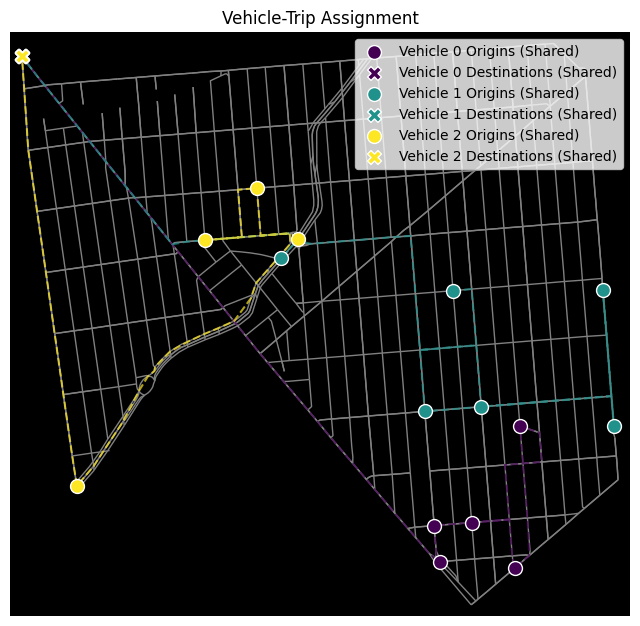

In [64]:
# Plotting MOD map
import numpy as np
def get_request_path_nodes(graph, request):
    """Gets the nodes along the shortest path for a single request."""
    try:
        path = nx.shortest_path(graph, request['origin'], request['destination'], weight='length')
        return path
    except nx.NetworkXNoPath:
        return None

def plot_assignments(graph, assignment, requests):
    """Plots the network graph with assigned routes and request points."""

    request_dict = {req['id']: req for req in requests}

    all_assigned_route_nodes = set()
    for vehicle_id, trip in assignment.items():
        if trip['type'] == 'individual':
            req = request_dict[trip['requests'][0]]
            path_nodes = get_request_path_nodes(graph, req)
            if path_nodes:
                all_assigned_route_nodes.update(path_nodes)
        elif trip['type'] == 'shared':
            request_nodes = []
            for req_id in trip['requests']:
                 req = request_dict[req_id]
                 request_nodes.append(req['origin'])
                 request_nodes.append(req['destination'])
            all_assigned_route_nodes.update(request_nodes)

    fig, ax = ox.plot_graph(graph, node_size=0, edge_color='gray', show=False, close=False, bgcolor='black')

    route_colors = plt.cm.viridis(np.linspace(0, 1, len(assignment)))
    for i, (vehicle_id, trip) in enumerate(assignment.items()):
        color = route_colors[i]

        if trip['type'] == 'individual':
            req = request_dict[trip['requests'][0]]
            path_nodes = get_request_path_nodes(graph, req)
            if path_nodes:
                 x = [graph.nodes[n]['x'] for n in path_nodes]
                 y = [graph.nodes[n]['y'] for n in path_nodes]
                 ax.plot(x, y, color=color, linewidth=2, label=f'Vehicle {vehicle_id} (Req {trip["requests"][0]})')

                 ax.scatter(graph.nodes[req['origin']]['x'], graph.nodes[req['origin']]['y'], color=color, s=100, marker='o', edgecolors='white', zorder=5)
                 ax.scatter(graph.nodes[req['destination']]['x'], graph.nodes[req['destination']]['y'], color=color, s=100, marker='X', edgecolors='white', zorder=5)

        elif trip['type'] == 'shared':
            origin_nodes = [request_dict[req_id]['origin'] for req_id in trip['requests']]
            destination_nodes = [request_dict[req_id]['destination'] for req_id in trip['requests']]

            origin_x = [graph.nodes[n]['x'] for n in origin_nodes]
            origin_y = [graph.nodes[n]['y'] for n in origin_nodes]
            destination_x = [graph.nodes[n]['x'] for n in destination_nodes]
            destination_y = [graph.nodes[n]['y'] for n in destination_nodes]

            ax.scatter(origin_x, origin_y, color=color, s=100, marker='o', edgecolors='white', zorder=5, label=f'Vehicle {vehicle_id} Origins (Shared)')
            ax.scatter(destination_x, destination_y, color=color, s=100, marker='X', edgecolors='white', zorder=5, label=f'Vehicle {vehicle_id} Destinations (Shared)')

            simplified_nodes_sequence = list(origin_nodes) + list(destination_nodes)
            try:
                 conceptual_path_x = []
                 conceptual_path_y = []
                 for k in range(len(simplified_nodes_sequence) - 1):
                      try:
                           path_segment = nx.shortest_path(graph, simplified_nodes_sequence[k], simplified_nodes_sequence[k+1], weight='length')
                           conceptual_path_x.extend([graph.nodes[n]['x'] for n in path_segment])
                           conceptual_path_y.extend([graph.nodes[n]['y'] for n in path_segment])
                      except nx.NetworkXNoPath:
                           pass
                 if conceptual_path_x:
                    ax.plot(conceptual_path_x, conceptual_path_y, color=color, linestyle='--', linewidth=1.5, alpha=0.7)
            except Exception as e:
                 print(f"Could not plot conceptual path for shared trip: {e}")


    unassigned_origins_x = []
    unassigned_origins_y = []
    unassigned_destinations_x = []
    unassigned_destinations_y = []

    unassigned_requests_info = [req for req in requests if req['id'] in unassigned_requests]

    for req in unassigned_requests_info:
        unassigned_origins_x.append(graph.nodes[req['origin']]['x'])
        unassigned_origins_y.append(graph.nodes[req['origin']]['y'])
        unassigned_destinations_x.append(graph.nodes[req['destination']]['x'])
        unassigned_destinations_y.append(graph.nodes[req['destination']]['y'])

    if unassigned_origins_x:
        ax.scatter(unassigned_origins_x, unassigned_origins_y, c='yellow', s=50, marker='o', edgecolors='black', label='Unassigned Origins', zorder=4)
    if unassigned_destinations_x:
        ax.scatter(unassigned_destinations_x, unassigned_destinations_y, c='yellow', s=50, marker='X', edgecolors='black', label='Unassigned Destinations', zorder=4)


    plt.title("Vehicle-Trip Assignment")
    plt.legend()
    plt.show()

plot_assignments(G, assignment, travel_requests)

In [76]:
# Total time per route and per passenger

print("\n--- Total Time Per Assigned Route ---")
for vehicle_id, trip in assignment.items():
    total_trip_length = trip['cost']
    estimated_trip_time_sec = total_trip_length / average_speed_mps
    estimated_trip_time_min = estimated_trip_time_sec / 60
    print(f"Vehicle {vehicle_id}: Estimated route time = {estimated_trip_time_min:.2f} minutes ({total_trip_length:.2f} meters)")

print("\n--- Estimated Travel Time Per Request (Accounting for Pickup Order) ---")
request_dict = {req['id']: req for req in travel_requests}

request_estimated_travel_time = {}

for vehicle_id, trip in assignment.items():
    if trip['type'] == 'individual':
        req_id = trip['requests'][0]
        total_trip_length = trip['cost']
        estimated_trip_time_min = (total_trip_length / average_speed_mps) / 60
        request_estimated_travel_time[req_id] = estimated_trip_time_min

    elif trip['type'] == 'shared':
        req_ids = trip['requests']
        requests_in_trip = [request_dict[req_id] for req_id in req_ids]

        requests_in_trip.sort(key=lambda r: r['id'])

        pickup_nodes_sequence = [req['origin'] for req in requests_in_trip]
        final_destination_node = requests_in_trip[0]['destination']
        segment_lengths = []
        last_node = final_destination_node
        sequence_to_calculate = pickup_nodes_sequence + [final_destination_node]

        for i in range(len(sequence_to_calculate) - 1, 0, -1):
             u = sequence_to_calculate[i-1]
             v = sequence_to_calculate[i]
             try:
                 length = nx.shortest_path_length(G_undirected, u, v, weight='length')
                 segment_lengths.insert(0, length)
             except nx.NetworkXNoPath:
                 print(f"Warning: No path found between {u} and {v} for shared trip. Cannot calculate precise travel time for this trip.")
                 segment_lengths = []
                 break

        if segment_lengths:
             cumulative_lengths_to_dest = [sum(segment_lengths[i:]) for i in range(len(segment_lengths))]

             for i, req in enumerate(requests_in_trip):
                  estimated_travel_time_sec = cumulative_lengths_to_dest[i] / average_speed_mps
                  estimated_travel_time_min = estimated_travel_time_sec / 60
                  request_estimated_travel_time[req['id']] = estimated_travel_time_min

for req in travel_requests:
    req_id = req['id']
    if req_id in request_estimated_travel_time:
        print(f"Request {req_id} (Assigned): Estimated travel time = {request_estimated_travel_time[req_id]:.2f} minutes")
    elif req_id in unassigned_requests:
        try:
             direct_length = nx.shortest_path_length(G_undirected, req['origin'], req['destination'], weight='length')
             direct_time_min = (direct_length / average_speed_mps) / 60
             print(f"Request {req_id} (Unassigned): Direct travel time = {direct_time_min:.2f} minutes (No assignment)")
        except nx.NetworkXNoPath:
              print(f"Request {req_id} (Unassigned): No direct path found")
    else:
        print(f"Request {req_id}: Status unclear")

total_individual_travel_time = sum(request_estimated_travel_time.values())
number_of_assigned_requests = len(request_estimated_travel_time)

if number_of_assigned_requests > 0:
    average_individual_travel_time = total_individual_travel_time / number_of_assigned_requests
    print(f"\nAverage Estimated Travel Time per Assigned Request: {average_individual_travel_time:.2f} minutes")
else:
    print("\nNo requests were assigned, cannot calculate average individual travel time.")


--- Total Time Per Assigned Route ---
Vehicle 0: Estimated route time = 20.25 minutes (4859.21 meters)
Vehicle 1: Estimated route time = 27.08 minutes (6498.76 meters)
Vehicle 2: Estimated route time = 18.79 minutes (4509.52 meters)

--- Estimated Travel Time Per Request (Accounting for Pickup Order) ---
Request 0 (Assigned): Estimated travel time = 20.25 minutes
Request 1 (Assigned): Estimated travel time = 27.08 minutes
Request 2 (Assigned): Estimated travel time = 18.79 minutes
Request 3 (Assigned): Estimated travel time = 17.06 minutes
Request 4 (Assigned): Estimated travel time = 24.26 minutes
Request 5 (Assigned): Estimated travel time = 18.93 minutes
Request 6 (Assigned): Estimated travel time = 18.67 minutes
Request 7 (Assigned): Estimated travel time = 15.97 minutes
Request 8 (Assigned): Estimated travel time = 15.18 minutes
Request 9 (Assigned): Estimated travel time = 12.60 minutes
Request 10 (Assigned): Estimated travel time = 7.85 minutes
Request 11 (Assigned): Estimated 